```
conda create --name pct1 python=3.10
conda install jupyter
conda install scipy
conda install seaborn
conda install scikit-learn
conda install tensorflow
```

## Imports

In [1]:
import sys; sys.path.insert(0, "..")
import os

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.typing import NDArray
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

In [3]:
from sshaves import SSHAVESEstimator, WhitenedADADTester_MonteCarlo, HACSubspaceClusterer, KSADTester
from subspace_tree import SubsapceTreeBuilder, SubspaceTreeNode
from utils import random_sample

#### Importing Datasets

In [4]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X_digits = x_train.reshape((60_000, 28*28))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_fashion = x_train.reshape((60_000, 28*28))

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
sns.set_theme(style="ticks")

## Building Trees

#### Helpers...

In [6]:
def project_to_common_svs(X, low_dim):
    new_svs = np.flip(np.arange(low_dim) + 1) * 5
    U, s, VT = LA.svd(X, full_matrices=False)
    s[:] = 0.0
    s[:low_dim] = new_svs
    return U @ np.diag(s) @ VT

def prune_tree_to_size(t, size):
    nodes = t.get_descendents()
    while len(t.get_descendents()) > size:
        node_svs = [(n, n.singular_value)for n in nodes]
        node_svs_ordered = sorted(node_svs, key=lambda n: n[1])
        smallest_node = node_svs_ordered[0][0]
        smallest_node.leaf_die()
    return t

In [7]:
T_max = 100
alpha_test = "0.001"
clusterer = HACSubspaceClusterer()

In [8]:
hypothesis_tester = KSADTester()
subspace_tester = SSHAVESEstimator(hypothesis_tester, alpha_test, significant_test_increase=1.0)
clusterer = HACSubspaceClusterer()

#### MNIST Digits

In [ ]:
digit_trees = []
T_max = 100
for i in range(3):
    X = random_sample(X_digits, 10_000) # bootstrap sample
    X_std = project_to_common_svs(X, 64)
    builder = SubsapceTreeBuilder(X_std, 10000, 600, subspace_tester, clusterer, None, T_max)
    root = builder.build_tree()
    root = prune_tree_to_size(root, T_max)
    digit_trees.append(root)

In [ ]:
fashion_trees = []
for i in range(3):
    X = random_sample(X_fashion, 10_000) # bootstrap sample
    X_std = project_to_common_svs(X, 64)
    builder = SubsapceTreeBuilder(X_std, 10000, 600, subspace_tester, clusterer, None, T_max)
    root = builder.build_tree()
    root = prune_tree_to_size(root, T_max)
    fashion_trees.append(root)

## Analyzing Trees

In [15]:
import copy 
def leaf_distribution(root, n_nodes):
    root_copy = copy.deepcopy(root)
    all_nodes = np.array(list(root_copy.get_descendents()))
    all_singular_values = np.array([n.singular_value for n in all_nodes])
    nodes_copy = all_nodes[all_singular_values.argsort()]
    n_leaves = len([n for n in list(all_nodes) if n.is_leaf])
    result = []
    for node in nodes_copy:
        result.append(n_leaves)
        lost_a_leaf = node.leaf_die()
        if lost_a_leaf:
            n_leaves -= 1
    return result[-n_nodes:]

def depth_distribution(root, max_depth, n_nodes):
    all_nodes = np.array(list(root.get_descendents()))
    try:
        all_singular_values = np.array([n.resid_sum_squares for n in all_nodes])
    except:
        return None, None
    smallest_tolerated_sv = np.sort(all_singular_values)[-n_nodes]
    filt_nodes = all_nodes[all_singular_values >= smallest_tolerated_sv]
    filt_nodes_depth = np.array([n.depth for n in filt_nodes])
    depth_vals = [(filt_nodes_depth<=dpth).sum() for dpth in range(max_depth)]
    return depth_vals, filt_nodes_depth


class TreeTestResult:
    def __init__(self, trees: list[SubspaceTreeNode], nodes: int) -> None:
        N = nodes
        self.trees = []
        self.all_trees = []
        for t in trees:
            print(len(t.get_descendents()))
            self.all_trees.append(t)
            if len(t.get_descendents()) == N:
                self.trees.append(t)
                
        validate_curve = lambda x: (x is not None) and (None not in x) and (np.nan not in x) and (x is not np.nan)

        self.all_height_curves = np.array([depth_distribution(t, N, N)[0] for t in self.trees])
        self.height_curve_valid = np.array([validate_curve(h) for h in self.all_height_curves])
        self.height_curves: NDArray = np.vstack(self.all_height_curves[self.height_curve_valid]).astype(float)
        self.mean_height_curve = self.height_curves.mean(axis=0)

        self.all_height_aucs = np.array([np.array(h).sum() if validate_curve(h) else 0 for h in self.all_height_curves])
        self.height_aucs = self.all_height_aucs[self.height_curve_valid]


        self.all_width_curves = np.array([leaf_distribution(t, N) for t in self.trees])
        self.width_curve_valid = np.array([validate_curve(h) for h in self.all_width_curves])
        self.width_curves: NDArray = np.vstack(self.all_width_curves[self.width_curve_valid]).astype(float)
        self.mean_width_curve = self.width_curves.mean(axis=0)

        self.all_width_aucs = np.array([w.sum() if validate_curve(w) else 0 for w in self.all_width_curves])
        self.width_aucs = self.all_width_aucs[self.width_curve_valid]

        self.both_valid = self.width_curve_valid * self.height_curve_valid
        self.combined_aucs = self.all_width_aucs[self.both_valid] + self.all_height_aucs[self.both_valid]

In [ ]:
digit_tree_results = TreeTestResult(digit_trees, 100)
fashion_tree_results = TreeTestResult(fashion_trees, 100)

## Visualizing Results

Text(0.5, 1.0, 'MNIST Digits vs Fashion Height Curves')

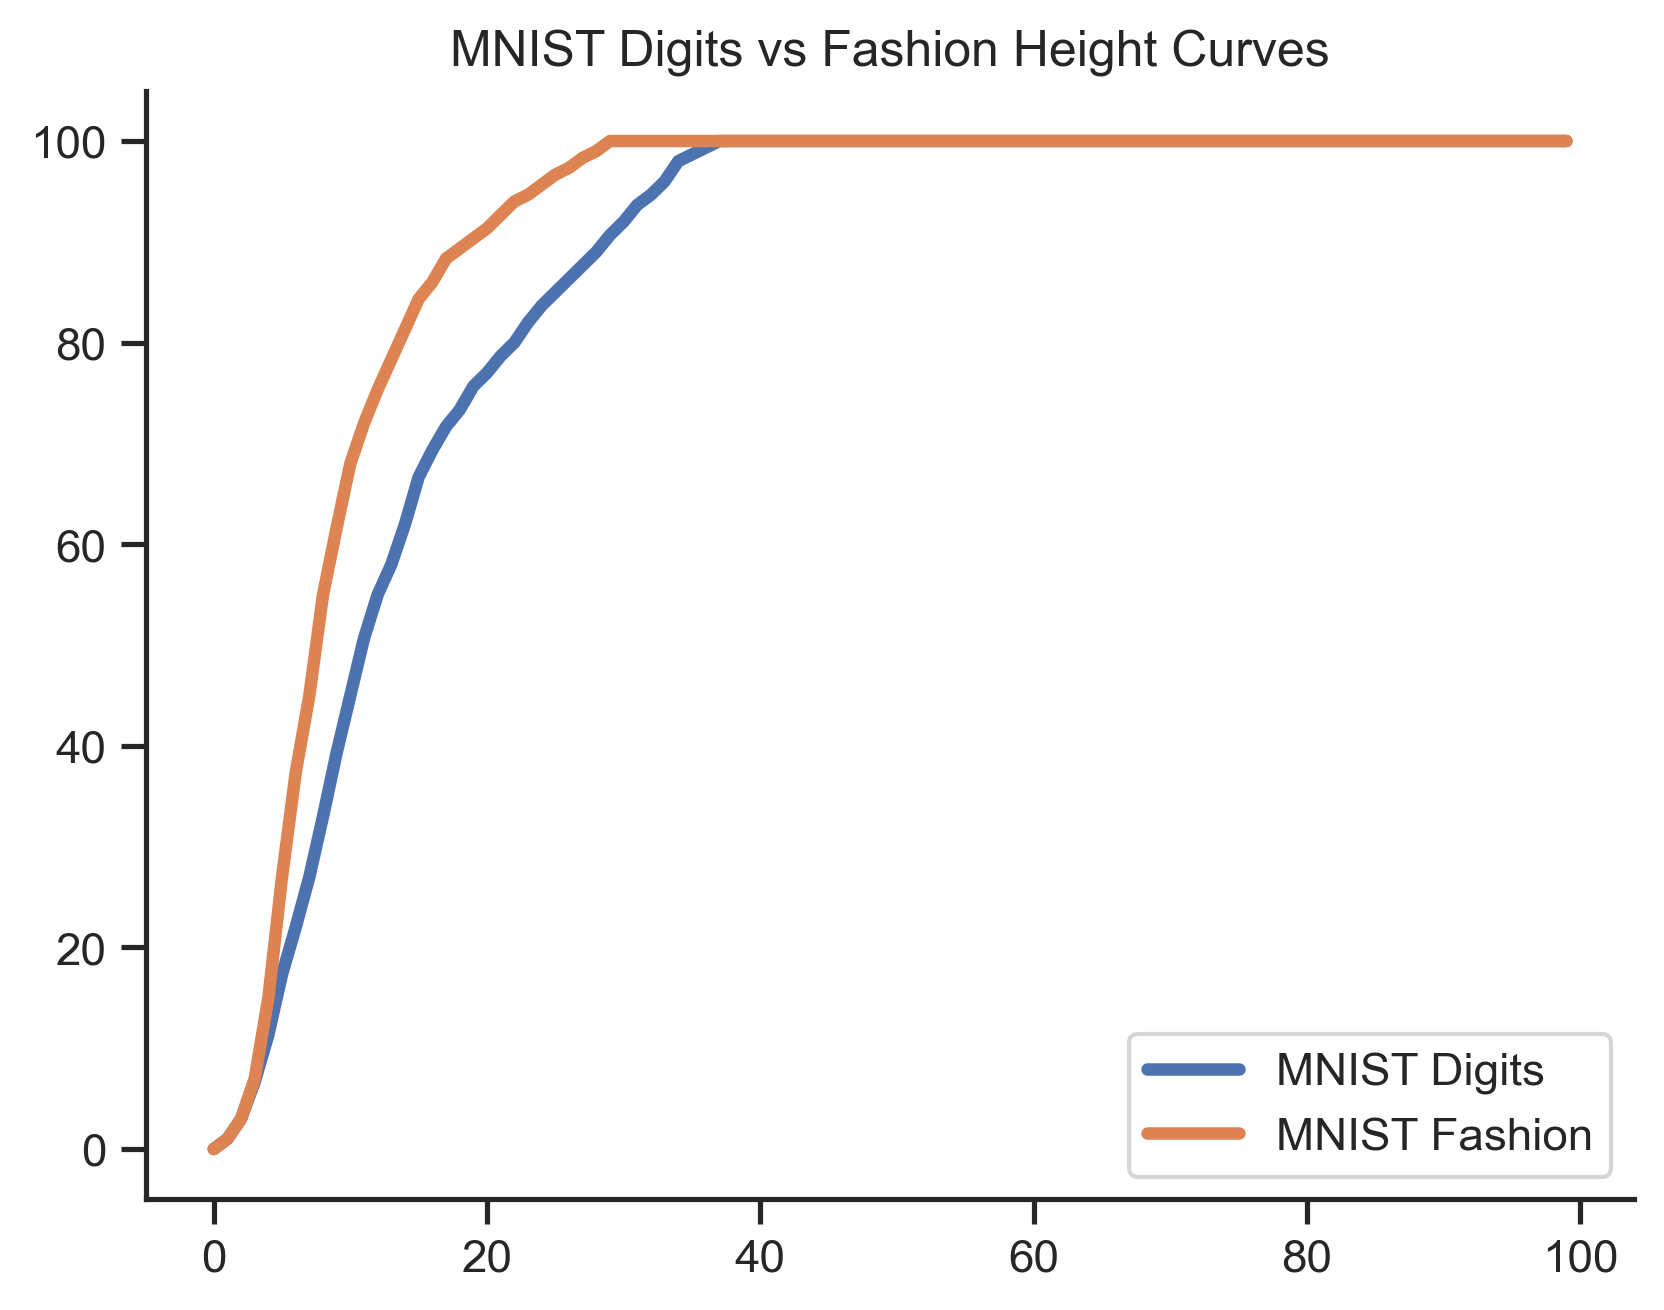

In [17]:
fig, ax = plt.subplots()
sns.despine()
ax.plot(digit_tree_results.mean_height_curve, label="MNIST Digits", linewidth=3)
ax.plot(fashion_tree_results.mean_height_curve, label="MNIST Fashion", linewidth=3)
ax.legend()
ax.set_title("MNIST Digits vs Fashion Height Curves")

Text(0.5, 1.0, 'MNIST Digits vs Fashion Width Curves')

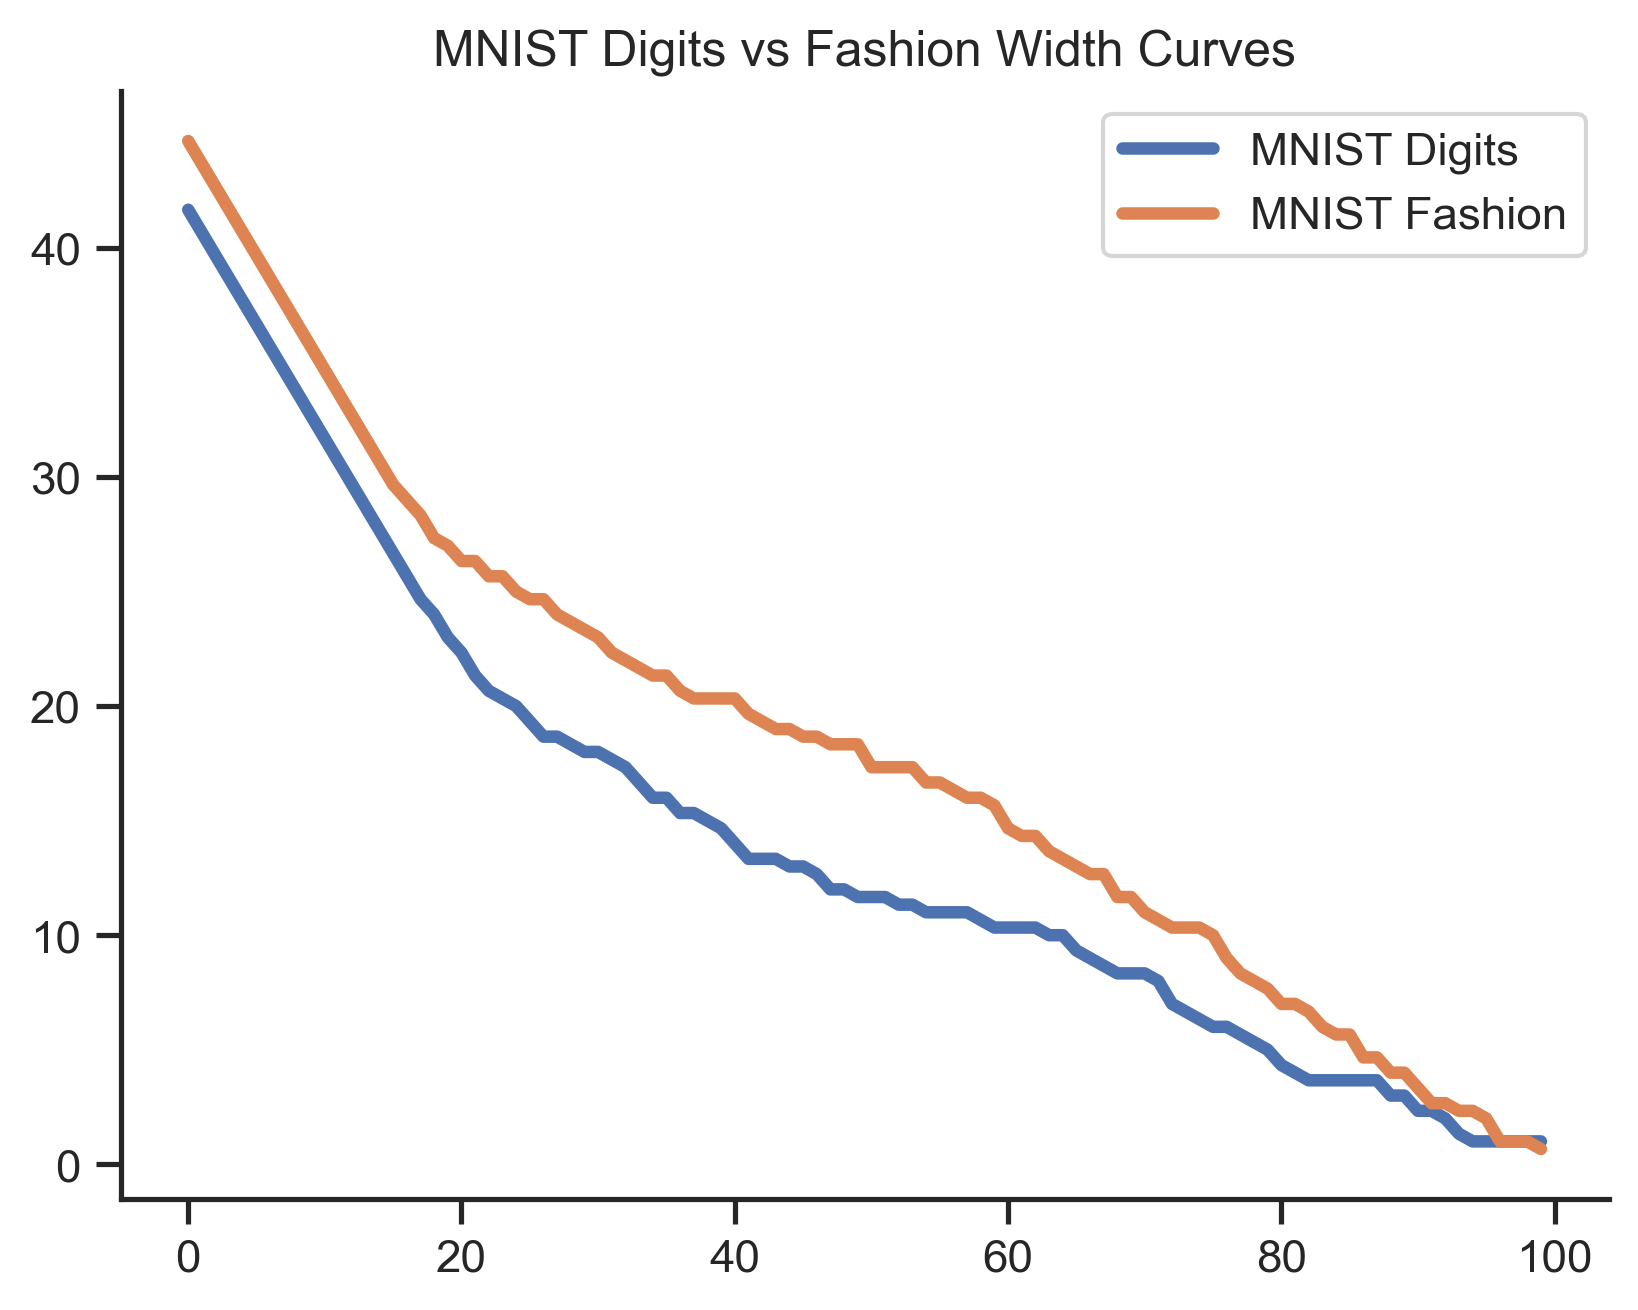

In [18]:
fig, ax = plt.subplots()
sns.despine()
ax.plot(digit_tree_results.mean_width_curve, label="MNIST Digits", linewidth=3)
ax.plot(fashion_tree_results.mean_width_curve, label="MNIST Fashion", linewidth=3)
ax.legend()
ax.set_title("MNIST Digits vs Fashion Width Curves")